In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
# The Data Preprocessing


def load_data():
    print("Loading MNIST Data...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # --- Preprocessing for LeNet-5 (CNN) ---
    # LeNet-5 originally expects 32x32 inputs. MNIST is 28x28.
    # We pad the images with zeros to reach 32x32.
    x_train_lenet = np.pad(x_train, ((0,0),(2,2),(2,2)), 'constant')
    x_test_lenet = np.pad(x_test, ((0,0),(2,2),(2,2)), 'constant')



    # Add channel dimension: (Batch, 32, 32, 1)
    x_train_lenet = x_train_lenet[..., np.newaxis]
    x_test_lenet = x_test_lenet[..., np.newaxis]


    # --- Preprocessing for ANN (MLP) ---
    # ANN expects a flat vector of pixels: (Batch, 784)
    x_train_ann = x_train.reshape((-1, 784))
    x_test_ann = x_test.reshape((-1, 784))


    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    return (x_train_lenet, x_test_lenet, x_train_ann, x_test_ann, y_train, y_test)

# Run the function to load data into memory
x_train_lenet, x_test_lenet, x_train_ann, x_test_ann, y_train, y_test = load_data()
print("Data loaded and shaped!")

Loading MNIST Data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data loaded and shaped!


In [4]:
# LeNet-5 uses convolutions (Conv2D) to scan for features and AveragePooling2D to reduce size. It ends with Dense layers for classification.

def build_lenet5():
    model = models.Sequential([
        # Layer 1: Convolution (Scan for edges)
        layers.Input(shape=(32, 32, 1)),
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh'),
        layers.AveragePooling2D(pool_size=(2, 2)),

        # Layer 2: Convolution (Scan for shapes)
        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        layers.AveragePooling2D(pool_size=(2, 2)),

        # Flatten: Convert 2D maps to 1D vector
        layers.Flatten(),

        # Layer 3-5: Fully Connected Classification
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(10, activation='softmax')
    ], name="LeNet-5")
    return model

lenet_model = build_lenet5()
lenet_model.summary()

Model: "LeNet-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#  Building the ANN (The "Memorizer")

# The ANN is much simpler. It takes the flattened input (784 pixels) and passes it through standard dense layers. It lacks spatial awareness.


def build_ann():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ], name="Standard_ANN")
    return model

ann_model = build_ann()
ann_model.summary()

Model: "Standard_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Training LeNet-5...
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.8543 - loss: 0.4993 - val_accuracy: 0.9632 - val_loss: 0.1168
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9653 - loss: 0.1107 - val_accuracy: 0.9771 - val_loss: 0.0701
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9800 - loss: 0.0630 - val_accuracy: 0.9811 - val_loss: 0.0593
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.9864 - loss: 0.0443 - val_accuracy: 0.9821 - val_loss: 0.0613
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.9887 - loss: 0.0353 - val_accuracy: 0.9824 - val_loss: 0.0556

Training Standard_ANN...
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8636 - loss: 0.4861 - val_accuracy: 0.9597 - val_loss: 0.1353
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9636 - loss: 0.1197 - val_accuracy: 0.9693 - val_loss: 0.1043
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - a

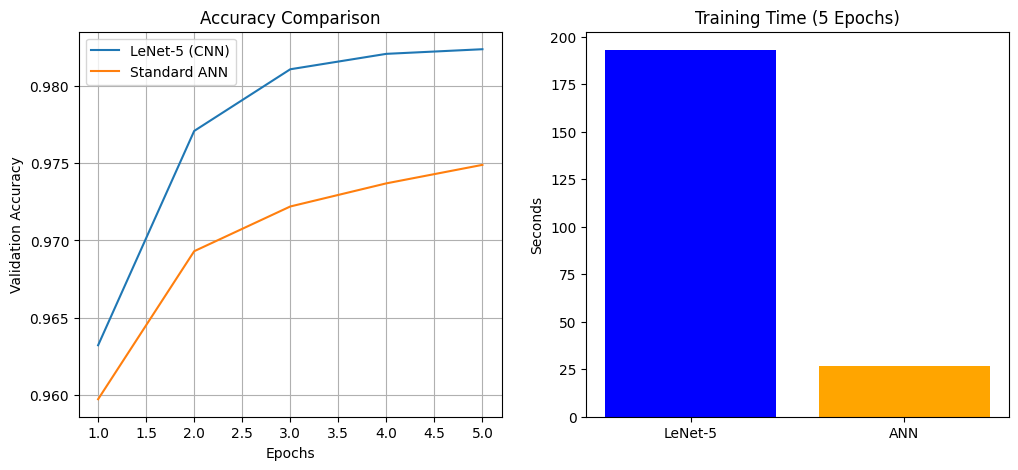

LeNet-5 Accuracy: 98.24%
ANN Accuracy:     97.49%


In [6]:
# Now we train both models and plot the results side-by-side to compare accuracy and speed.


def train_model(model, x_train, y_train, x_test, y_test):
    print(f"\nTraining {model.name}...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=1)
    end = time.time()

    return history, end - start

# Train LeNet
lenet_hist, lenet_time = train_model(lenet_model, x_train_lenet, y_train, x_test_lenet, y_test)

# Train ANN
ann_hist, ann_time = train_model(ann_model, x_train_ann, y_train, x_test_ann, y_test)

# --- Plotting Results ---
epochs_range = range(1, 6)
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, lenet_hist.history['val_accuracy'], label='LeNet-5 (CNN)')
plt.plot(epochs_range, ann_hist.history['val_accuracy'], label='Standard ANN')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Time Plot
plt.subplot(1, 2, 2)
plt.bar(['LeNet-5', 'ANN'], [lenet_time, ann_time], color=['blue', 'orange'])
plt.title('Training Time (5 Epochs)')
plt.ylabel('Seconds')

plt.show()

print(f"LeNet-5 Accuracy: {max(lenet_hist.history['val_accuracy'])*100:.2f}%")
print(f"ANN Accuracy:     {max(ann_hist.history['val_accuracy'])*100:.2f}%")


LeNet-5 (~99%): Because LeNet uses Convolutions, it understands that a pixel at (x,y) is related to its neighbors. If a "loop" (like the top of a 9) appears slightly to the left or right, the convolution filter still catches it. This is called Translation Invariance.

ANN (~97%): The ANN flattens the image into a single line. It loses the concept of "up", "down", "left", or "right". If you shift a digit by just one pixel, the ANN sees a completely different input vector and might fail to recognize it.

LeNet-5 is often more efficient with memory storage (fewer parameters) because it "shares" weights. A single edge-detection filter is used across the entire image.

ANN requires a massive number of weights because every single input pixel must have its own unique connection to every neuron in the next layer.